In [1]:
from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import os

os.listdir('../../data')

['train_bt_en.csv',
 'preprocessed_train.csv',
 'train.csv',
 'test.json',
 'train_bt_ja.csv',
 'train_rd.csv',
 'train_rs.csv',
 'wordnet.pickle']

In [9]:
tmp = pd.read_csv('../../data/preprocessed_train.csv')

# len(tmp) * 0.8, len(tmp) * 0.8 + len(tmp) * 0.1

t = tmp[:int(len(tmp)*0.6)]
v = tmp[int(len(tmp)*0.6):int(len(tmp)*0.8)]
_t = tmp[int(len(tmp)*0.8):]

len(t), len(v), len(_t)

(2370, 790, 790)

In [20]:
class ClassifierModel():
    def __init__(self, datasets=['preprocessed_train'], frac=0.5):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = Mecab()
        self.stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
        
        self.vocab_size = None
        self.word_vector_dim = 128
        
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.x_val = None
        self.y_val = None
        
        self.preprocess(datasets, frac)
        
        self.model = self.CNN()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    
    def data_load(self, datasets, frac):
        
        _dir = '../../data'
        
        trains = []
        vals = []
        tests = []
        
        for ds in datasets:
            _df = pd.read_csv(f'{_dir}/{ds}.csv')
            
            _train = _df[:int(len(_df)*0.6)]
            _val = _df[int(len(_df)*0.6):int(len(_df)*0.8)]
            _test = _df[int(len(_df)*0.8):]
            
            if ds == 'preprocessed_train':
                vals.append(_val)
                tests.append(_test)
            else:
                _train = _train.sample(frac=frac)
                
            trains.append(_train)
            
        train = pd.concat(trains)
        train.drop_duplicates(inplace=True)
        val = pd.concat(vals)
        val.drop_duplicates(inplace=True)
        test = pd.concat(tests)
        test.drop_duplicates(inplace=True)
        
        return train, val, test
    

    def preprocess_sentence(self, sentence):

        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()

        return sentence
    
    
    def tokenize(self, it):
        result = []
        for sentence in it:
            temp = self.tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in self.stopwords] 
            result.append(temp)
        return result
    
    
    def pad_sequences(self, it, word_to_index):
        return tf.keras.preprocessing.sequence.pad_sequences(
            it, value=word_to_index["<PAD>"], padding='pre', maxlen=400)
    
    
    def preprocess(self, datasets, frac):
        
        train, val, test = self.data_load(datasets, frac)
        train['data'] = train['data'].apply(lambda it : self.preprocess_sentence(it))
        val['data'] = val['data'].apply(lambda it : self.preprocess_sentence(it))
        test['data'] = test['data'].apply(lambda it : self.preprocess_sentence(it))
        
        
        x_train = self.tokenize(train['data'])
        x_test = self.tokenize(test['data'])
        x_val = self.tokenize(val['data'])
        
        self.y_train = tf.keras.utils.to_categorical(train['label'], num_classes=4, dtype='float32')
        self.y_val = tf.keras.utils.to_categorical(val['label'], num_classes=4, dtype='float32')
        self.y_test = tf.keras.utils.to_categorical(test['label'], num_classes=4, dtype='float32')
        
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(10000-4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        word_to_index = { word:index for index, word in enumerate(vocab) }
        
        self.vocab_size = len(word_to_index)
        
        def wordlist_to_index_list(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
        x_train = list(map(wordlist_to_index_list, x_train))
        x_test = list(map(wordlist_to_index_list, x_test))
        x_val = list(map(wordlist_to_index_list, x_val))  
        
        self.x_train = self.pad_sequences(x_train, word_to_index)
        self.x_val = self.pad_sequences(x_val, word_to_index)
        self.x_test = self.pad_sequences(x_test, word_to_index)
    

    def CNN(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(embedding)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=20, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Epoch 1/20
38/38 [==============================] - 1s 18ms/step - loss: 1.3592 - accuracy: 0.3295 - val_loss: 1.2957 - val_accuracy: 0.4759
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 1.2173 - accuracy: 0.5131 - val_loss: 1.1173 - val_accuracy: 0.6506
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.9783 - accuracy: 0.6515 - val_loss: 0.8433 - val_accuracy: 0.7291
Epoch 4/20
38/38 [==============================] - 0s 6ms/step - loss: 0.7012 - accuracy: 0.7671 - val_loss: 0.6511 - val_accuracy: 0.7759
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.5193 - accuracy: 0.8439 - val_loss: 0.5752 - val_accuracy: 0.7911
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 0.3599 - accuracy: 0.9038 - val_loss: 0.5345 - val_accuracy: 0.8013
Epoch 7/20
38/38 [==============================] - 0s 6ms/step - loss: 0.2525 - accuracy: 0.9392 - val_loss: 0.5280 - val_accuracy: 0.8101
Epoch 8/20
38/38 [=

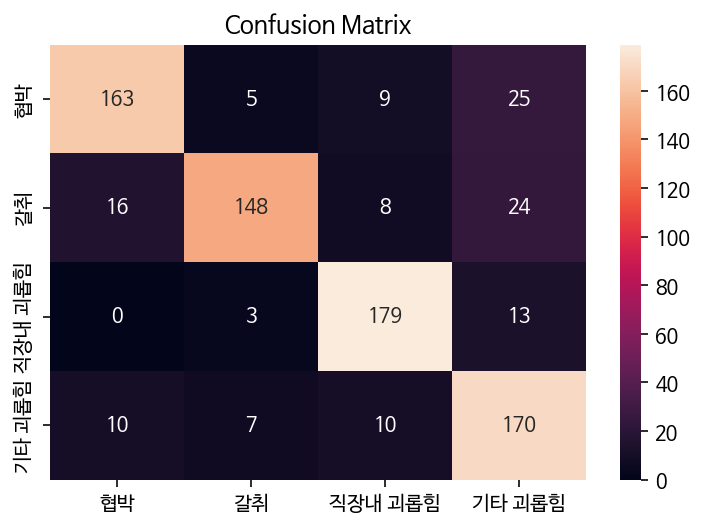

In [37]:
model = ClassifierModel(datasets=['preprocessed_train'], frac=1)
model.train()
model.show_report()

Epoch 1/20
47/47 [==============================] - 37s 22ms/step - loss: 1.3452 - accuracy: 0.3639 - val_loss: 1.2533 - val_accuracy: 0.6506
Epoch 2/20
47/47 [==============================] - 0s 6ms/step - loss: 1.0665 - accuracy: 0.6269 - val_loss: 0.8733 - val_accuracy: 0.7063
Epoch 3/20
47/47 [==============================] - 0s 6ms/step - loss: 0.7363 - accuracy: 0.7603 - val_loss: 0.6641 - val_accuracy: 0.7696
Epoch 4/20
47/47 [==============================] - 0s 5ms/step - loss: 0.4925 - accuracy: 0.8562 - val_loss: 0.5401 - val_accuracy: 0.8152
Epoch 5/20
47/47 [==============================] - 0s 5ms/step - loss: 0.3106 - accuracy: 0.9223 - val_loss: 0.4783 - val_accuracy: 0.8354
Epoch 6/20
47/47 [==============================] - 0s 5ms/step - loss: 0.2107 - accuracy: 0.9541 - val_loss: 0.4598 - val_accuracy: 0.8392
Epoch 7/20
47/47 [==============================] - 0s 5ms/step - loss: 0.1389 - accuracy: 0.9710 - val_loss: 0.4624 - val_accuracy: 0.8430
Epoch 8/20
47/47 [

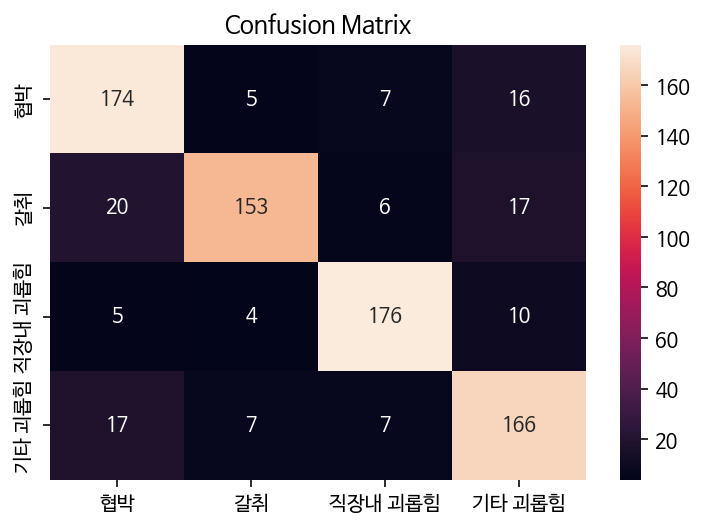

In [21]:
rs_25 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=0.25)
rs_25.train()
rs_25.show_report()

Epoch 1/20
56/56 [==============================] - 1s 14ms/step - loss: 1.3044 - accuracy: 0.4281 - val_loss: 1.1160 - val_accuracy: 0.6861
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 0.8899 - accuracy: 0.7015 - val_loss: 0.7287 - val_accuracy: 0.7570
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 0.5537 - accuracy: 0.8228 - val_loss: 0.5559 - val_accuracy: 0.7949
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 0.3325 - accuracy: 0.9091 - val_loss: 0.4930 - val_accuracy: 0.8266
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 0.1877 - accuracy: 0.9564 - val_loss: 0.4904 - val_accuracy: 0.8342
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 0.1120 - accuracy: 0.9781 - val_loss: 0.4982 - val_accuracy: 0.8456
Epoch 7/20
56/56 [==============================] - 0s 6ms/step - loss: 0.0761 - accuracy: 0.9859 - val_loss: 0.5379 - val_accuracy: 0.8418
Epoch 8/20
56/56 [=

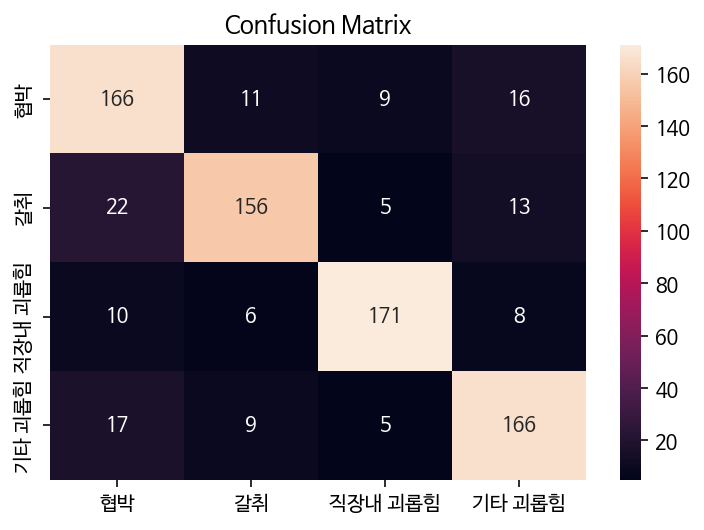

In [22]:
rs_50 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=0.50)
rs_50.train()
rs_50.show_report()

Epoch 1/20
65/65 [==============================] - 1s 12ms/step - loss: 1.3026 - accuracy: 0.4127 - val_loss: 1.1241 - val_accuracy: 0.6873
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9562 - accuracy: 0.6309 - val_loss: 0.7150 - val_accuracy: 0.7646
Epoch 3/20
65/65 [==============================] - 0s 6ms/step - loss: 0.5914 - accuracy: 0.8071 - val_loss: 0.5464 - val_accuracy: 0.8076
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3594 - accuracy: 0.8951 - val_loss: 0.4903 - val_accuracy: 0.8304
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1936 - accuracy: 0.9556 - val_loss: 0.5089 - val_accuracy: 0.8266
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1216 - accuracy: 0.9725 - val_loss: 0.5292 - val_accuracy: 0.8278
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0872 - accuracy: 0.9822 - val_loss: 0.5676 - val_accuracy: 0.8392
Epoch 8/20
65/65 [=

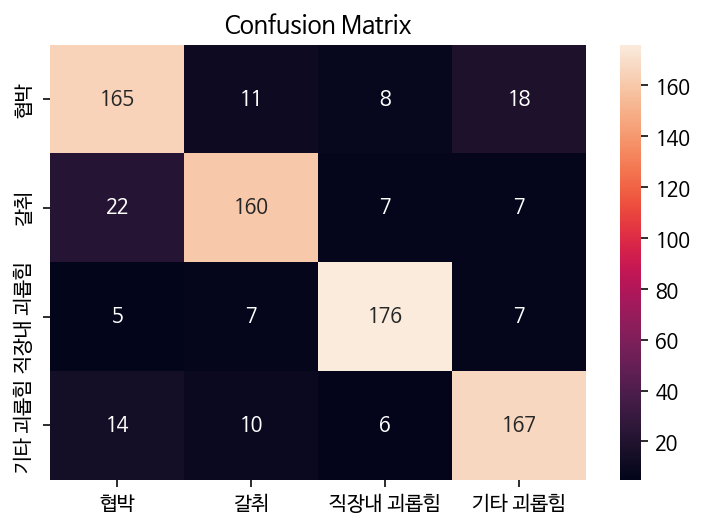

In [23]:
rs_75 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=0.75)
rs_75.train()
rs_75.show_report()

Epoch 1/20
75/75 [==============================] - 1s 10ms/step - loss: 1.2646 - accuracy: 0.4432 - val_loss: 0.9911 - val_accuracy: 0.6266
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8447 - accuracy: 0.6909 - val_loss: 0.6593 - val_accuracy: 0.7709
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5220 - accuracy: 0.8316 - val_loss: 0.5396 - val_accuracy: 0.8051
Epoch 4/20
75/75 [==============================] - 0s 5ms/step - loss: 0.3119 - accuracy: 0.9097 - val_loss: 0.5046 - val_accuracy: 0.8177
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1790 - accuracy: 0.9576 - val_loss: 0.5201 - val_accuracy: 0.8228
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1143 - accuracy: 0.9734 - val_loss: 0.5477 - val_accuracy: 0.8342
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0727 - accuracy: 0.9838 - val_loss: 0.5983 - val_accuracy: 0.8316
Epoch 8/20
75/75 [=

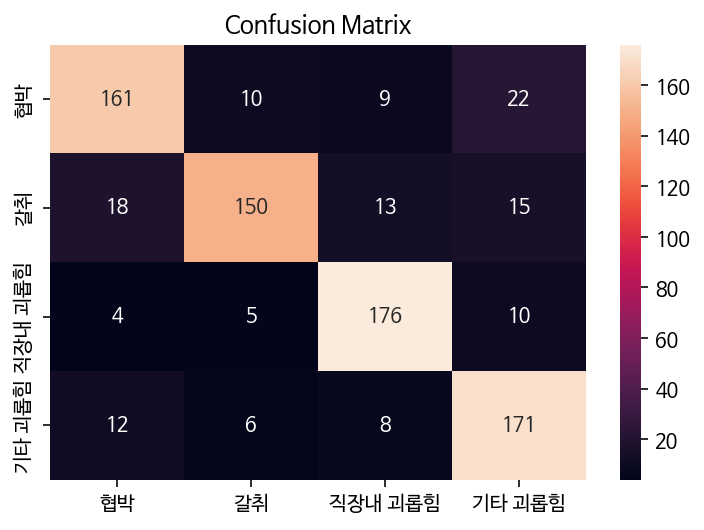

In [24]:
rs_100 = ClassifierModel(datasets=['preprocessed_train', 'train_rs'], frac=1)
rs_100.train()
rs_100.show_report()

Epoch 1/20
47/47 [==============================] - 1s 10ms/step - loss: 1.3481 - accuracy: 0.3761 - val_loss: 1.2575 - val_accuracy: 0.6342
Epoch 2/20
47/47 [==============================] - 0s 6ms/step - loss: 1.1064 - accuracy: 0.5989 - val_loss: 0.8934 - val_accuracy: 0.7190
Epoch 3/20
47/47 [==============================] - 0s 5ms/step - loss: 0.7651 - accuracy: 0.7286 - val_loss: 0.6574 - val_accuracy: 0.7772
Epoch 4/20
47/47 [==============================] - 0s 5ms/step - loss: 0.5210 - accuracy: 0.8359 - val_loss: 0.5356 - val_accuracy: 0.8177
Epoch 5/20
47/47 [==============================] - 0s 5ms/step - loss: 0.3417 - accuracy: 0.9112 - val_loss: 0.5015 - val_accuracy: 0.8241
Epoch 6/20
47/47 [==============================] - 0s 5ms/step - loss: 0.2421 - accuracy: 0.9325 - val_loss: 0.4862 - val_accuracy: 0.8266
Epoch 7/20
47/47 [==============================] - 0s 5ms/step - loss: 0.1698 - accuracy: 0.9564 - val_loss: 0.4929 - val_accuracy: 0.8241
Epoch 8/20
47/47 [=

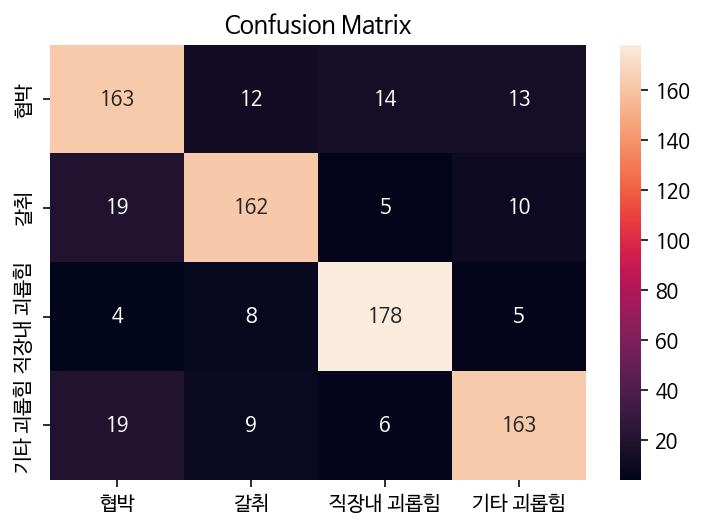

In [25]:
rd_25 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=0.25)
rd_25.train()
rd_25.show_report()

Epoch 1/20
56/56 [==============================] - 1s 8ms/step - loss: 1.3195 - accuracy: 0.3744 - val_loss: 1.1804 - val_accuracy: 0.6076
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 0.9877 - accuracy: 0.6354 - val_loss: 0.7878 - val_accuracy: 0.7456
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 0.6504 - accuracy: 0.7828 - val_loss: 0.5763 - val_accuracy: 0.7962
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 0.4011 - accuracy: 0.8869 - val_loss: 0.5146 - val_accuracy: 0.8165
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 0.2676 - accuracy: 0.9291 - val_loss: 0.4916 - val_accuracy: 0.8304
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 0.1678 - accuracy: 0.9567 - val_loss: 0.4852 - val_accuracy: 0.8342
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 0.1195 - accuracy: 0.9679 - val_loss: 0.5046 - val_accuracy: 0.8316
Epoch 8/20
56/56 [==

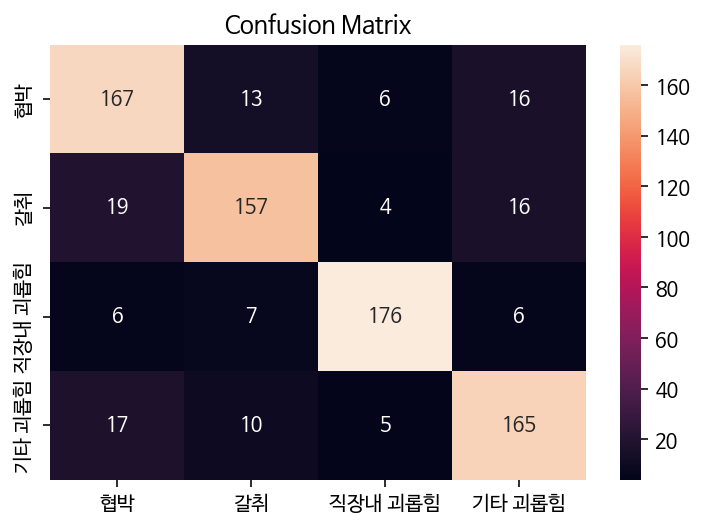

In [26]:
rd_50 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=0.50)
rd_50.train()
rd_50.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.2934 - accuracy: 0.4335 - val_loss: 1.0661 - val_accuracy: 0.6759
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.8500 - accuracy: 0.6999 - val_loss: 0.6808 - val_accuracy: 0.7709
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5488 - accuracy: 0.8139 - val_loss: 0.5457 - val_accuracy: 0.8013
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3279 - accuracy: 0.9077 - val_loss: 0.5140 - val_accuracy: 0.8139
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1946 - accuracy: 0.9474 - val_loss: 0.5048 - val_accuracy: 0.8342
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1174 - accuracy: 0.9757 - val_loss: 0.5205 - val_accuracy: 0.8380
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0869 - accuracy: 0.9790 - val_loss: 0.5505 - val_accuracy: 0.8405
Epoch 8/20
65/65 [==

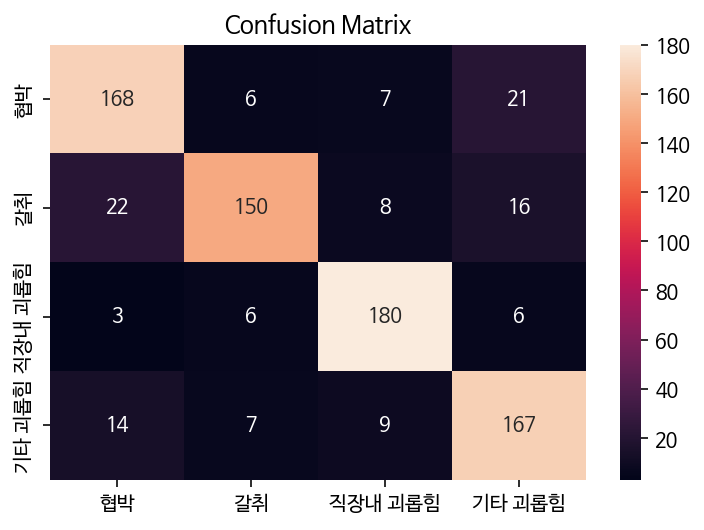

In [27]:
rd_75 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=0.75)
rd_75.train()
rd_75.show_report()

Epoch 1/20
75/75 [==============================] - 1s 8ms/step - loss: 1.2712 - accuracy: 0.4302 - val_loss: 1.0191 - val_accuracy: 0.6911
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8384 - accuracy: 0.7034 - val_loss: 0.6868 - val_accuracy: 0.7709
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5137 - accuracy: 0.8278 - val_loss: 0.5412 - val_accuracy: 0.8101
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.3185 - accuracy: 0.9135 - val_loss: 0.4889 - val_accuracy: 0.8291
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1821 - accuracy: 0.9527 - val_loss: 0.5073 - val_accuracy: 0.8190
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1007 - accuracy: 0.9806 - val_loss: 0.5370 - val_accuracy: 0.8266
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0737 - accuracy: 0.9859 - val_loss: 0.5758 - val_accuracy: 0.8241
Epoch 8/20
75/75 [==

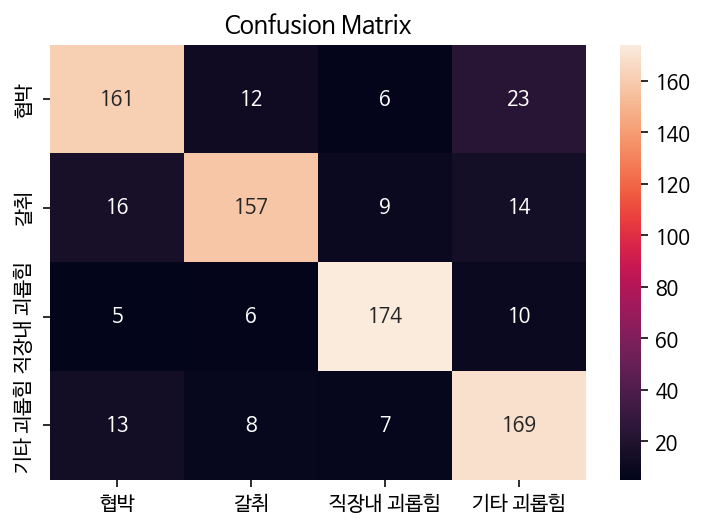

In [28]:
rd_100 = ClassifierModel(datasets=['preprocessed_train', 'train_rd'], frac=1)
rd_100.train()
rd_100.show_report()

Epoch 1/20
47/47 [==============================] - 1s 9ms/step - loss: 1.3507 - accuracy: 0.3714 - val_loss: 1.2398 - val_accuracy: 0.5367
Epoch 2/20
47/47 [==============================] - 0s 6ms/step - loss: 1.1304 - accuracy: 0.5402 - val_loss: 0.9346 - val_accuracy: 0.6797
Epoch 3/20
47/47 [==============================] - 0s 6ms/step - loss: 0.8456 - accuracy: 0.6867 - val_loss: 0.6947 - val_accuracy: 0.7532
Epoch 4/20
47/47 [==============================] - 0s 6ms/step - loss: 0.6177 - accuracy: 0.7863 - val_loss: 0.5816 - val_accuracy: 0.7949
Epoch 5/20
47/47 [==============================] - 0s 6ms/step - loss: 0.4384 - accuracy: 0.8670 - val_loss: 0.5173 - val_accuracy: 0.8266
Epoch 6/20
47/47 [==============================] - 0s 6ms/step - loss: 0.2949 - accuracy: 0.9227 - val_loss: 0.4915 - val_accuracy: 0.8228
Epoch 7/20
47/47 [==============================] - 0s 6ms/step - loss: 0.2049 - accuracy: 0.9510 - val_loss: 0.4998 - val_accuracy: 0.8177
Epoch 8/20
47/47 [==

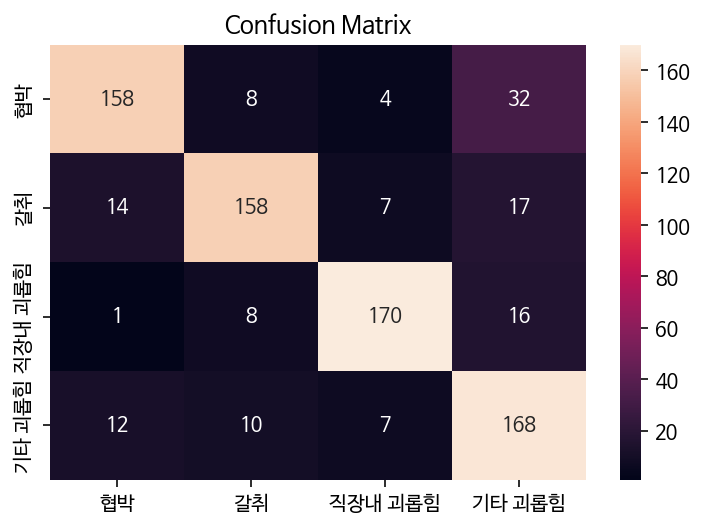

In [29]:
bt_en_25 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=0.25)
bt_en_25.train()
bt_en_25.show_report()

Epoch 1/20
56/56 [==============================] - 1s 8ms/step - loss: 1.3438 - accuracy: 0.3598 - val_loss: 1.2336 - val_accuracy: 0.6253
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 1.0716 - accuracy: 0.5857 - val_loss: 0.8364 - val_accuracy: 0.7203
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 0.7597 - accuracy: 0.7333 - val_loss: 0.6233 - val_accuracy: 0.7911
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 0.5177 - accuracy: 0.8374 - val_loss: 0.5330 - val_accuracy: 0.8228
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 0.3527 - accuracy: 0.8982 - val_loss: 0.4963 - val_accuracy: 0.8291
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 0.2290 - accuracy: 0.9426 - val_loss: 0.4926 - val_accuracy: 0.8266
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 0.1556 - accuracy: 0.9612 - val_loss: 0.4955 - val_accuracy: 0.8342
Epoch 8/20
56/56 [==

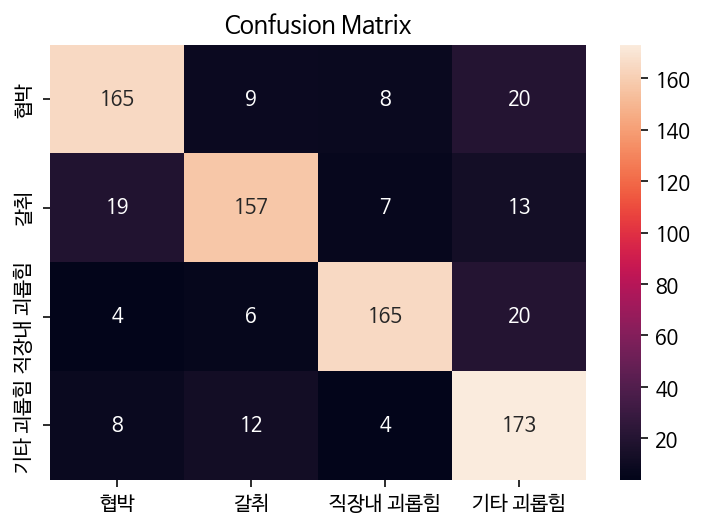

In [30]:
bt_en_50 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=0.5)
bt_en_50.train()
bt_en_50.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3075 - accuracy: 0.3949 - val_loss: 1.0989 - val_accuracy: 0.6291
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9211 - accuracy: 0.6622 - val_loss: 0.6922 - val_accuracy: 0.7646
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5928 - accuracy: 0.7953 - val_loss: 0.5383 - val_accuracy: 0.8076
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3762 - accuracy: 0.8867 - val_loss: 0.4883 - val_accuracy: 0.8253
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2373 - accuracy: 0.9361 - val_loss: 0.4736 - val_accuracy: 0.8367
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1463 - accuracy: 0.9675 - val_loss: 0.4882 - val_accuracy: 0.8405
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0922 - accuracy: 0.9802 - val_loss: 0.5213 - val_accuracy: 0.8367
Epoch 8/20
65/65 [==

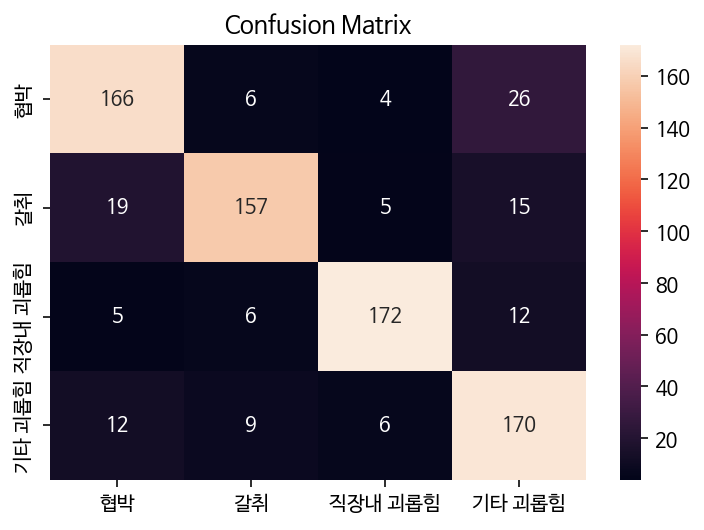

In [31]:
bt_en_75 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=0.75)
bt_en_75.train()
bt_en_75.show_report()

Epoch 1/20
75/75 [==============================] - 1s 7ms/step - loss: 1.3062 - accuracy: 0.3947 - val_loss: 1.0556 - val_accuracy: 0.6506
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8783 - accuracy: 0.6802 - val_loss: 0.6622 - val_accuracy: 0.7823
Epoch 3/20
75/75 [==============================] - 0s 5ms/step - loss: 0.5912 - accuracy: 0.8049 - val_loss: 0.5462 - val_accuracy: 0.8114
Epoch 4/20
75/75 [==============================] - 0s 5ms/step - loss: 0.3845 - accuracy: 0.8833 - val_loss: 0.4938 - val_accuracy: 0.8190
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.2452 - accuracy: 0.9386 - val_loss: 0.4891 - val_accuracy: 0.8304
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1544 - accuracy: 0.9622 - val_loss: 0.5138 - val_accuracy: 0.8392
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.0947 - accuracy: 0.9814 - val_loss: 0.5522 - val_accuracy: 0.8354
Epoch 8/20
75/75 [==

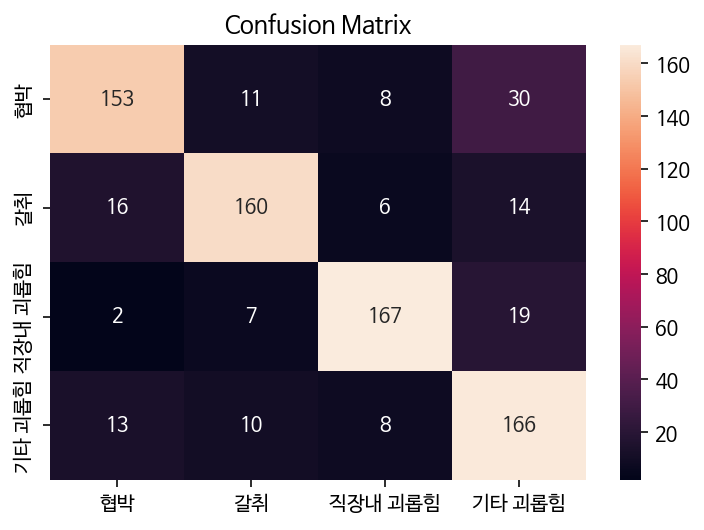

In [32]:
bt_en_100 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_en'], frac=1)
bt_en_100.train()
bt_en_100.show_report()

Epoch 1/20
47/47 [==============================] - 1s 10ms/step - loss: 1.3632 - accuracy: 0.3258 - val_loss: 1.3015 - val_accuracy: 0.6646
Epoch 2/20
47/47 [==============================] - 0s 6ms/step - loss: 1.1849 - accuracy: 0.5270 - val_loss: 0.9859 - val_accuracy: 0.6823
Epoch 3/20
47/47 [==============================] - 0s 6ms/step - loss: 0.8698 - accuracy: 0.6874 - val_loss: 0.7020 - val_accuracy: 0.7810
Epoch 4/20
47/47 [==============================] - 0s 6ms/step - loss: 0.6249 - accuracy: 0.7988 - val_loss: 0.5626 - val_accuracy: 0.8000
Epoch 5/20
47/47 [==============================] - 0s 6ms/step - loss: 0.4185 - accuracy: 0.8717 - val_loss: 0.4980 - val_accuracy: 0.8165
Epoch 6/20
47/47 [==============================] - 0s 6ms/step - loss: 0.2653 - accuracy: 0.9328 - val_loss: 0.4749 - val_accuracy: 0.8241
Epoch 7/20
47/47 [==============================] - 0s 5ms/step - loss: 0.1849 - accuracy: 0.9548 - val_loss: 0.4829 - val_accuracy: 0.8215
Epoch 8/20
47/47 [=

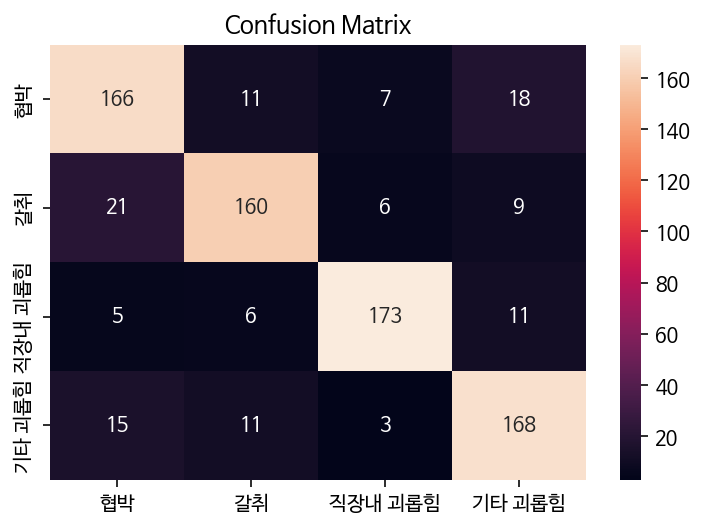

In [33]:
bt_ja_25 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=0.25)
bt_ja_25.train()
bt_ja_25.show_report()

Epoch 1/20
56/56 [==============================] - 1s 9ms/step - loss: 1.3330 - accuracy: 0.3786 - val_loss: 1.2014 - val_accuracy: 0.6443
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 1.0488 - accuracy: 0.6068 - val_loss: 0.8328 - val_accuracy: 0.7342
Epoch 3/20
56/56 [==============================] - 0s 6ms/step - loss: 0.7155 - accuracy: 0.7558 - val_loss: 0.6147 - val_accuracy: 0.7823
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 0.4878 - accuracy: 0.8523 - val_loss: 0.5211 - val_accuracy: 0.8139
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 0.3216 - accuracy: 0.9075 - val_loss: 0.5098 - val_accuracy: 0.8203
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 0.2206 - accuracy: 0.9432 - val_loss: 0.4957 - val_accuracy: 0.8241
Epoch 7/20
56/56 [==============================] - 0s 5ms/step - loss: 0.1440 - accuracy: 0.9640 - val_loss: 0.5168 - val_accuracy: 0.8291
Epoch 8/20
56/56 [==

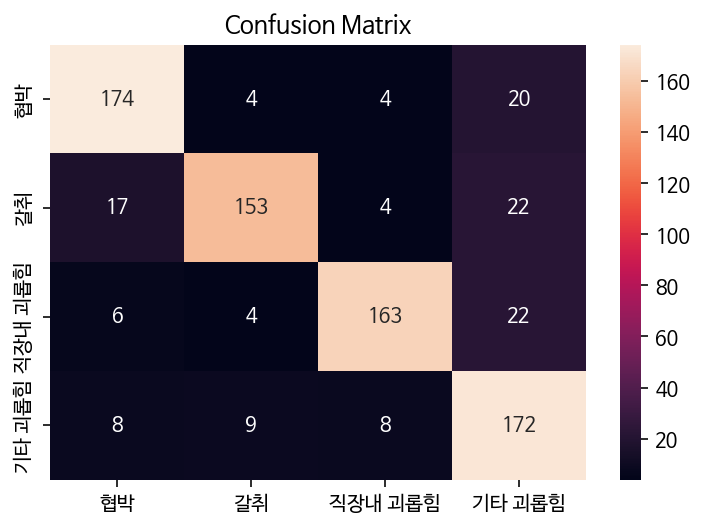

In [34]:
bt_ja_50 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=0.5)
bt_ja_50.train()
bt_ja_50.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3243 - accuracy: 0.3896 - val_loss: 1.1471 - val_accuracy: 0.5696
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9915 - accuracy: 0.6176 - val_loss: 0.7417 - val_accuracy: 0.7494
Epoch 3/20
65/65 [==============================] - 0s 6ms/step - loss: 0.6857 - accuracy: 0.7664 - val_loss: 0.5749 - val_accuracy: 0.8000
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.4754 - accuracy: 0.8484 - val_loss: 0.5170 - val_accuracy: 0.8253
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3329 - accuracy: 0.9000 - val_loss: 0.4989 - val_accuracy: 0.8304
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2150 - accuracy: 0.9450 - val_loss: 0.4949 - val_accuracy: 0.8304
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1412 - accuracy: 0.9619 - val_loss: 0.5262 - val_accuracy: 0.8316
Epoch 8/20
65/65 [==

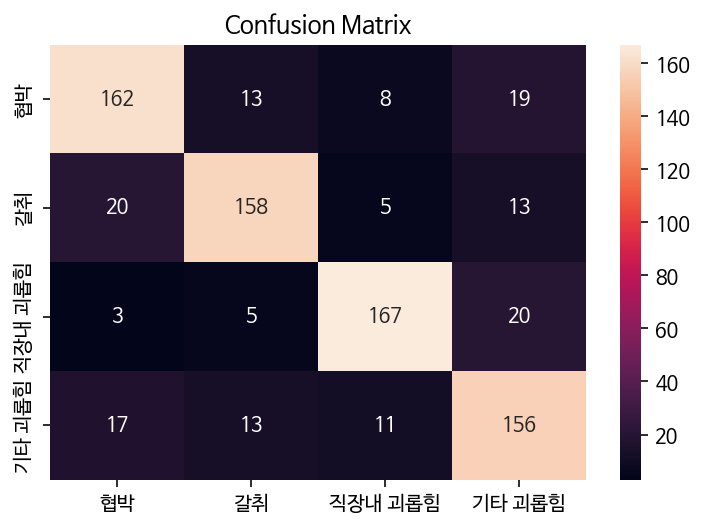

In [35]:
bt_ja_75 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=0.75)
bt_ja_75.train()
bt_ja_75.show_report()

Epoch 1/20
75/75 [==============================] - 1s 8ms/step - loss: 1.2974 - accuracy: 0.4297 - val_loss: 1.0429 - val_accuracy: 0.6557
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 0.9031 - accuracy: 0.6677 - val_loss: 0.6573 - val_accuracy: 0.7696
Epoch 3/20
75/75 [==============================] - 0s 5ms/step - loss: 0.5948 - accuracy: 0.8006 - val_loss: 0.5210 - val_accuracy: 0.8114
Epoch 4/20
75/75 [==============================] - 0s 5ms/step - loss: 0.3940 - accuracy: 0.8787 - val_loss: 0.4715 - val_accuracy: 0.8177
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.2493 - accuracy: 0.9354 - val_loss: 0.4754 - val_accuracy: 0.8215
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1639 - accuracy: 0.9584 - val_loss: 0.4743 - val_accuracy: 0.8316
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.1107 - accuracy: 0.9724 - val_loss: 0.5212 - val_accuracy: 0.8304
Epoch 8/20
75/75 [==

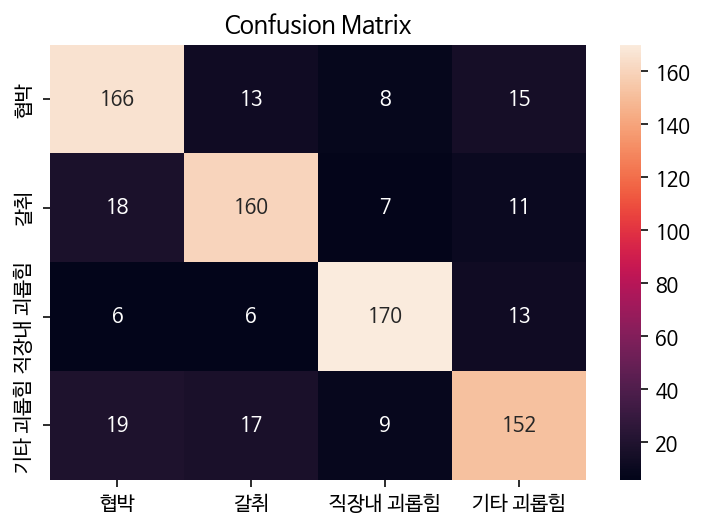

In [36]:
bt_ja_100 = ClassifierModel(datasets=['preprocessed_train', 'train_bt_ja'], frac=1)
bt_ja_100.train()
bt_ja_100.show_report()